In [1]:
import os
import re
import time

import lda
import nltk
import numpy as np
from nltk.tokenize import word_tokenize
from pymongo import MongoClient
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from scipy.sparse import dok_matrix
import matplotlib.pyplot as plt

In [2]:
MONGO_URL = 'mongodb://um.media.mit.edu:27017/super-glue'
db = MongoClient(MONGO_URL).get_default_database()

In [3]:
nlp_data = db['nlp_data'].find_one()
stopwords = nlp_data["stopwords"]
vocab = nlp_data["vocab_non_stemmed"]
vocab_dict = nlp_data["vocab_non_stemmed_dict"]

In [87]:
doc1 = """The birch canoe slid on the smooth planks.
Glue the sheet to the dark blue background.
It's easy to canoe tell the depth of a well.
These served days a chicken leg canoe is a rare dish.
Rice is often boy served in round bowls.
The juice of lemons makes fine punch.
The box stockings salmon was thrown beside the parked truck.
The hogs were trump trump trump fed chopped corn and garbage.
Four hours of steady work faced us.
Large size in stockings is hard to sell."""

doc2 = """The boy was there when the sun rose.
A rod is used to catch pink canoe salmon.
The source of the huge river is the clear spring.
Kick the ball straight and follow through.
Help the boy salmon woman get back to her feet.
A pot of tea helps trump to pass the evening.
Smoky fires lack flame fish and heat.
The soft  stockings cushion salmon broke the man's fall.
The salt breeze boy came across from the sea.
The girl at the booth sold fifty bonds."""

doc3 = """The small pup gnawed a hole in the sock.
The fish twisted and turned on the bent hook.
Press the pants and sew a button on the vest.
The swan dive was far short of perfect.
The beauty of the view stunned the young boy.
Two blue boy fish swam fish in the tank.
Her purse was full of useless trash.
The colt reared and threw the tall rider.
It snowed, rained, and hailed the same morning.
Read verse out loud for pleasure."""

document1 = """Python is a 2000 made-for-TV horror movie directed by Richard
Clabaugh. The film features several cult favorite actors, including William
Zabka of The Karate Kid fame, Wil Wheaton, Casper Van Dien, Jenny McCarthy,
Keith Coogan, Robert Englund (best known for his role as Freddy Krueger in the
A Nightmare on Elm Street series of films), Dana Barron, David Bowe, and Sean
Whalen. The film concerns a genetically engineered snake, a python, that
escapes and unleashes itself on a small town. It includes the classic final
girl scenario evident in films like Friday the 13th. It was filmed in Los Angeles,
 California and Malibu, California. Python was followed by two sequels: Python
 II (2002) and Boa vs. Python (2004), both also made-for-TV films."""

document2 = """Python, from the Greek word (πύθων/πύθωνας), is a genus of
nonvenomous pythons[2] found in Africa and Asia. Currently, 7 species are
recognised.[2] A member of this genus, P. reticulatus, is among the longest
snakes known."""

document3 = """The Colt Python is a .357 Magnum caliber revolver formerly
manufactured by Colt's Manufacturing Company of Hartford, Connecticut.
It is sometimes referred to as a "Combat Magnum".[1] It was first introduced
in 1955, the same year as Smith &amp; Wesson's M29 .44 Magnum. The now discontinued
Colt Python targeted the premium revolver market segment. Some firearm
collectors and writers such as Jeff Cooper, Ian V. Hogg, Chuck Hawks, Leroy
Thompson, Renee Smeets and Martin Dougherty have described the Python as the
finest production revolver ever made."""

docs = [document1, document2, document3]


In [4]:
DAY = 86400000
def millis():
    return int(round(time.time() * 1000))
def millis_since(num_days='2'):
    days = int(os.environ.get('TIME_FRAME_DAYS', num_days))
    return millis() - days*DAY

def get_vectors(media):
    segs = media["story_segments"]
    segs_vectors = []
    for i in range (len(segs)):
        start = segs[i]["start"]
        end = segs[i]["end"]
        length = float(end)-float(start)
        if "word_count" in segs[i]:
            vector = segs[i]["word_count"]
            if len(vector.keys())>3 and length>4000:
                segs_vectors.append(vector)
    return segs_vectors

def get_all_segments():
    all_media_has_segments = db['media'].find({"date_added": {"$gt": millis_since('1')},"story_segments":{"$exists": True},"is_news":{"$eq": True}})
    num_of_videos = all_media_has_segments.count()
    print "%d videos"%num_of_videos
    # total_segments = 0
    all_segments = []
    for media in all_media_has_segments:
        segs = get_vectors(media)
        all_segments.extend(segs)
    print "%d total segments"%len(all_segments)
    return all_segments

word_counts = get_all_segments()

120 videos
469 total segments


In [5]:
def get_count_vector(text):
    pattern = re.compile('[\W_]+')
    parts = [pattern.sub('', token).lower() for token in word_tokenize(text)]
    clean = [i for i in parts if i not in stopwords and len(re.findall('[a-zA-Z]', i)) > 2]
    text_processed = str.join(" ", clean)

    vocab_updated = False
    if len(clean) > 3:
        seg_vocab = CountVectorizer(stop_words=stopwords, ngram_range=(1, 1))
        seg_vector = seg_vocab.fit_transform([text_processed])
        seg_vocab_features = seg_vocab.get_feature_names()
        seg_vector_arr = seg_vector.toarray()
        added_words = []
        for word in seg_vocab_features:
            if (seg_vector_arr[0][seg_vocab.vocabulary_.get(word)] > 0) and not word in vocab:
                added_words.append(word)
        if len(added_words) > 0:
            i = len(vocab)
            vocab.extend(added_words)
            for word in added_words:
                vocab_dict[word] = i
                i+=1
            print "vocab_increased"
            print added_words
            vocab_updated = True

    cvectorizer = CountVectorizer(stop_words=stopwords, ngram_range=(1, 1), vocabulary=vocab)
    seg_vec = cvectorizer.transform([text_processed])
    arr = seg_vec.toarray()
    return {str(i): str(arr[0][i]) for i in np.nonzero(arr[0])[0]}

In [6]:
word_counts = [get_count_vector(doc) for doc in docs]

print word_counts

NameError: name 'docs' is not defined

In [7]:
tf_matrix = dok_matrix((len(word_counts), len(vocab)), dtype=np.int32)
for i, vec in enumerate(word_counts):
    for ind in vec.keys():
        tf_matrix[i, int(ind)] = int(vec[ind])
        
print tf_matrix.shape

(469, 33701)


In [114]:
sum_mat_axis_0 = tf_matrix.sum(axis=0)
sum_mat_axis_1 = tf_matrix.sum(axis=1)

In [148]:
print sum_mat_axis_0.shape
top_words_sorted = np.argsort(sum_mat_axis_0)[0][::-1]
print top_words_sorted
print top_words_sorted[0]
for i in range(30):
    print vocab[top_words_sorted[0, -i]]
    print sum_mat_axis_0[0, top_words_sorted[0, -i]]

(1, 33701)
[[    0 20629 20628 ..., 12746 30052 30924]]
[[    0 20629 20628 ..., 12746 30052 30924]]
100day
0
trump
1716
think
1037
going
920
people
856
donald
740
would
706
know
698
one
606
get
542
like
536
president
514
right
490
romney
485
presidentelect
483
said
456
see
451
want
424
lot
394
time
386
say
375
could
369
good
342
back
341
new
338
mitt
316
well
308
way
307
look
306
really
301


In [139]:
# normalize the tf matrix to tf-idf matrix
transformer = TfidfTransformer(norm=u'l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
tf_idf_matrix = transformer.fit_transform(tf_matrix)

In [30]:
keys = []
keys_indexes = {}
for d in word_counts:
    for key in d.keys():
        if key not in keys:
            keys.append(key)
            keys_indexes[key] = len(keys)-1

In [31]:
def sparse_matrix_to_arr(matrix):
    mat = np.zeros((len(word_counts), len(keys)))
    for d in matrix.keys():
        mat[d[0], keys_indexes[str(d[1])]] = matrix[d]
    return mat
    

In [32]:
tf = sparse_matrix_to_arr(tf_matrix)
tf_idf = sparse_matrix_to_arr(dok_matrix(tf_idf_matrix))

In [95]:
def float_matrix_to_ints (matrix):
    mat =  np.rint(np.multiply(matrix,1000))
    return mat.astype(int)
   

In [96]:
tf_idf_int = float_matrix_to_ints(tf_idf_matrix)
print tf_idf_int

  (0, 1083)	68
  (0, 1084)	39
  (0, 1182)	53
  (0, 1317)	86
  (0, 1378)	48
  (0, 1994)	51
  (0, 2298)	34
  (0, 2563)	51
  (0, 2601)	42
  (0, 2714)	31
  (0, 2778)	28
  (0, 2806)	27
  (0, 2947)	76
  (0, 3003)	22
  (0, 3089)	57
  (0, 3819)	25
  (0, 4001)	44
  (0, 4290)	48
  (0, 4303)	80
  (0, 4327)	73
  (0, 4483)	31
  (0, 4587)	34
  (0, 4765)	45
  (0, 4814)	114
  (0, 4857)	29
  :	:
  (468, 30052)	125
  (468, 30101)	60
  (468, 30272)	130
  (468, 30358)	43
  (468, 30412)	41
  (468, 30439)	57
  (468, 30543)	43
  (468, 30610)	56
  (468, 30723)	54
  (468, 30726)	51
  (468, 31401)	63
  (468, 32000)	54
  (468, 32211)	37
  (468, 32484)	35
  (468, 32560)	88
  (468, 32691)	37
  (468, 32692)	56
  (468, 32757)	29
  (468, 32811)	20
  (468, 33198)	37
  (468, 33204)	54
  (468, 33336)	70
  (468, 33402)	47
  (468, 33498)	84
  (468, 33580)	37


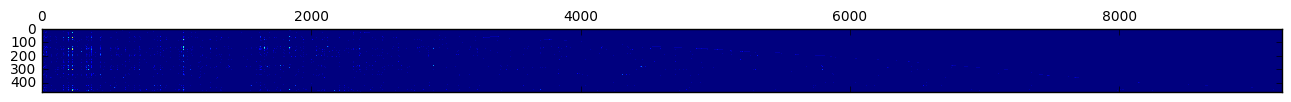

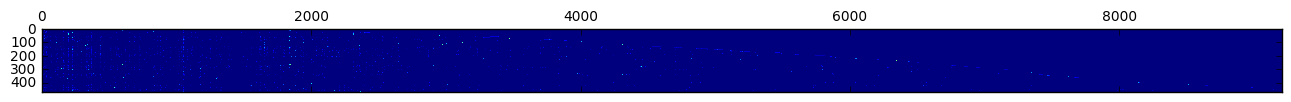

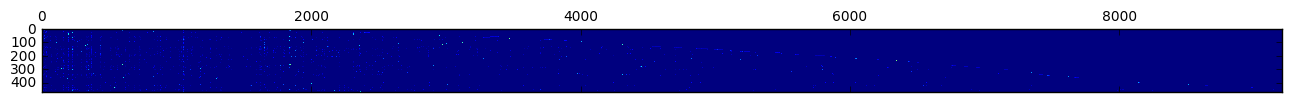

In [42]:

# print tf
# print tf_idf
plt.figure(figsize=(50,50))
plt.matshow(tf)

plt.matshow(tf_idf)
plt.matshow(sparse_matrix_to_arr(dok_matrix(tf_idf_int)))

plt.show()

# print tf_matrix
# print "------"
# print tf_idf_matrix

In [100]:
print int(tf_matrix.sum())

98295


In [98]:
n_topics = 50
n_iter = 300
t0 = time.time()
lda_model = lda.LDA(n_topics=n_topics, n_iter=n_iter)
X_topics = lda_model.fit_transform(tf_matrix)
print("done in %0.3fs." % (time.time() - t0))

INFO:lda:n_documents: 469
INFO:lda:vocab_size: 33701
INFO:lda:n_words: 98295
INFO:lda:n_topics: 50
INFO:lda:n_iter: 300
INFO:lda:<0> log likelihood: -1345018
INFO:lda:<10> log likelihood: -920023
INFO:lda:<20> log likelihood: -884395
INFO:lda:<30> log likelihood: -870343
INFO:lda:<40> log likelihood: -861503
INFO:lda:<50> log likelihood: -853593
INFO:lda:<60> log likelihood: -847804
INFO:lda:<70> log likelihood: -842665
INFO:lda:<80> log likelihood: -838445
INFO:lda:<90> log likelihood: -834907
INFO:lda:<100> log likelihood: -832285
INFO:lda:<110> log likelihood: -829713
INFO:lda:<120> log likelihood: -827763
INFO:lda:<130> log likelihood: -826135
INFO:lda:<140> log likelihood: -825418
INFO:lda:<150> log likelihood: -823843
INFO:lda:<160> log likelihood: -823148
INFO:lda:<170> log likelihood: -821387
INFO:lda:<180> log likelihood: -820841
INFO:lda:<190> log likelihood: -819592
INFO:lda:<200> log likelihood: -818128
INFO:lda:<210> log likelihood: -817289
INFO:lda:<220> log likelihood: -

done in 24.200s.


In [101]:
print int(tf_idf_int.sum())
t0 = time.time()
lda_model2 = lda.LDA(n_topics=n_topics, n_iter=n_iter)
X_topics_idf = lda_model2.fit_transform(tf_idf_int)
print("done in %0.3fs." % (time.time() - t0))

INFO:lda:n_documents: 469
INFO:lda:vocab_size: 33701
INFO:lda:n_words: 4168366
INFO:lda:n_topics: 50
INFO:lda:n_iter: 300


4168366


INFO:lda:<0> log likelihood: -52333058
INFO:lda:<10> log likelihood: -30037566
INFO:lda:<20> log likelihood: -29000314
INFO:lda:<30> log likelihood: -28623843
INFO:lda:<40> log likelihood: -28377137
INFO:lda:<50> log likelihood: -28200150
INFO:lda:<60> log likelihood: -28067433
INFO:lda:<70> log likelihood: -27963478
INFO:lda:<80> log likelihood: -27872633
INFO:lda:<90> log likelihood: -27794087
INFO:lda:<100> log likelihood: -27733853
INFO:lda:<110> log likelihood: -27682592
INFO:lda:<120> log likelihood: -27641014
INFO:lda:<130> log likelihood: -27596569
INFO:lda:<140> log likelihood: -27565085
INFO:lda:<150> log likelihood: -27534141
INFO:lda:<160> log likelihood: -27508378
INFO:lda:<170> log likelihood: -27478603
INFO:lda:<180> log likelihood: -27460386
INFO:lda:<190> log likelihood: -27441871
INFO:lda:<200> log likelihood: -27426574
INFO:lda:<210> log likelihood: -27405876
INFO:lda:<220> log likelihood: -27391944
INFO:lda:<230> log likelihood: -27376756
INFO:lda:<240> log likeliho

done in 750.937s.


In [14]:
alpha = 0.1
eta = 0.01
t0=time.time()
lda_model_scikit = LatentDirichletAllocation(n_topics=n_topics, max_iter=n_iter,
                            learning_method='batch',
                            doc_topic_prior=alpha,
                            topic_word_prior=eta)
doc_topic = lda_model_scikit.fit_transform(tf_matrix)
print("done in %0.3fs." % (time.time() - t0))
# topic_word = lda_model.components_  # get the topic words

done in 128.315s.


In [15]:
t0=time.time()
lda_model_scikit_idf = LatentDirichletAllocation(n_topics=n_topics, max_iter=n_iter,
                            learning_method='batch',
                            doc_topic_prior=alpha,
                            topic_word_prior=eta)
doc_topic_idf = lda_model_scikit_idf.fit_transform(tf_idf_matrix)
print("done in %0.3fs." % (time.time() - t0))

done in 86.708s.


In [93]:
def print_top_words(topic_word, n_top_words, lables, n_topics=None):
    lables_count = []
    for i in range(len(topic_word)):
        lables_count.append(0)
    for doc in lables[0]:
        lables_count[int(doc)]+=1
#     print lables_count
    
    sorted_topics = np.argsort(lables_count)[::-1]
    if not n_topics:
        n_topics = len(sorted_topics)
        
    for i in range(n_topics):
        topic_idx = sorted_topics[i]
        topic = topic_word[topic_idx]
        print("Topic #%d: - %d" % (topic_idx, lables_count[topic_idx]))
        print(" ".join([vocab[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [47]:
topic_word = lda_model.topic_word_
n_top_words = 8
# print_top_words(topic_word, n_top_words)


(469, 50)
(469, 50)
(469, 50)


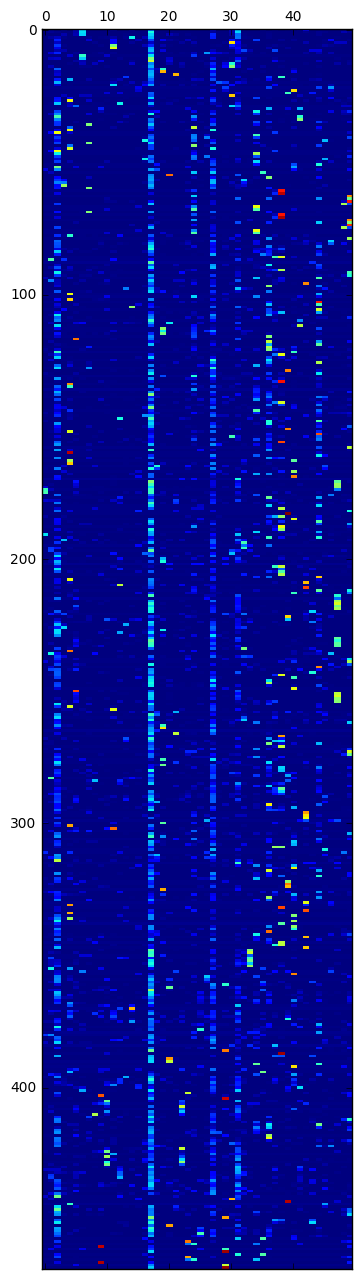

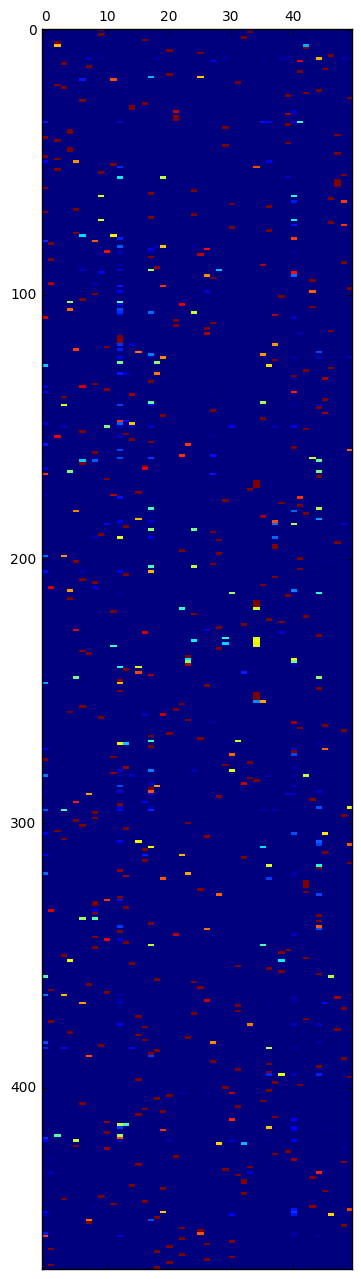

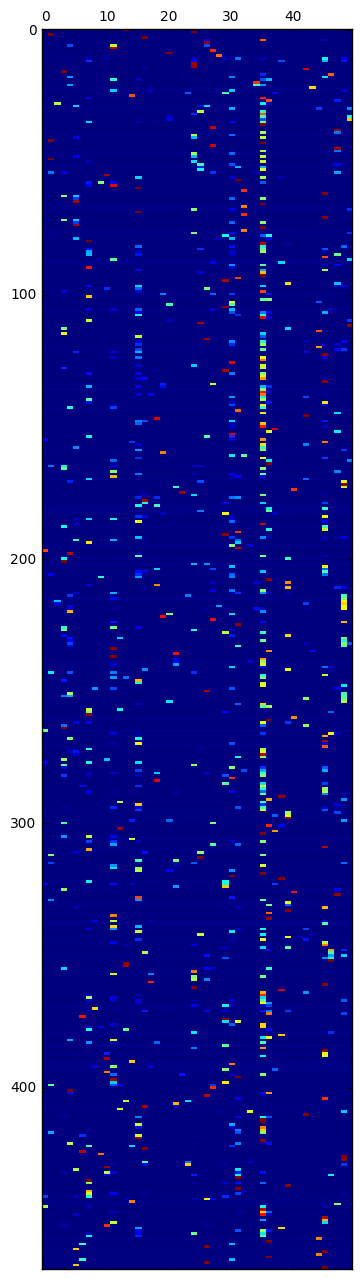

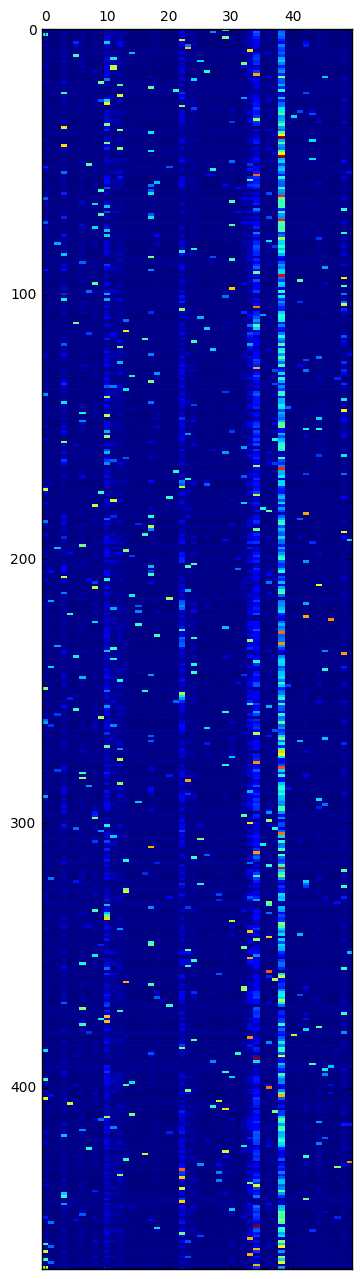

In [102]:
print X_topics.shape
print doc_topic.shape
print X_topics_idf.shape

plt.matshow(X_topics, aspect='auto')
plt.matshow(X_topics_idf, aspect='auto')
plt.matshow(doc_topic, aspect='auto')
plt.matshow(doc_topic_idf, aspect='auto')


plt.show()

In [49]:
def set_clusters(topics):
    dim = (1,topics.shape[0])
    aa = np.zeros(dim)
    for i, doc in enumerate(topics):
        aa[0, i] = doc.argmax()
    return aa

In [50]:
def lables_arr(topics):
    arr = []
    for doc in topics:
        arr.append(doc.argmax())
    return arr

In [103]:
X_topics_lables = set_clusters(X_topics)
X_topics_idf_lables = set_clusters(X_topics_idf)
doc_topic_lables = set_clusters(doc_topic)
doc_topic_idf_lables = set_clusters(doc_topic_idf)
print X_topics_lables.shape

(1, 469)


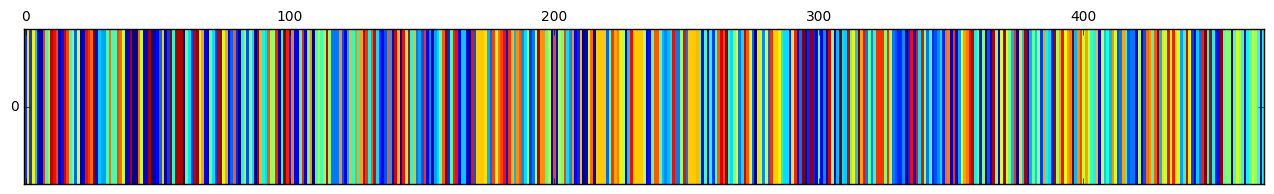

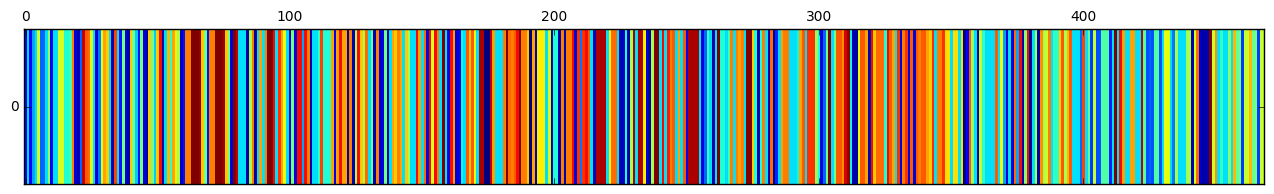

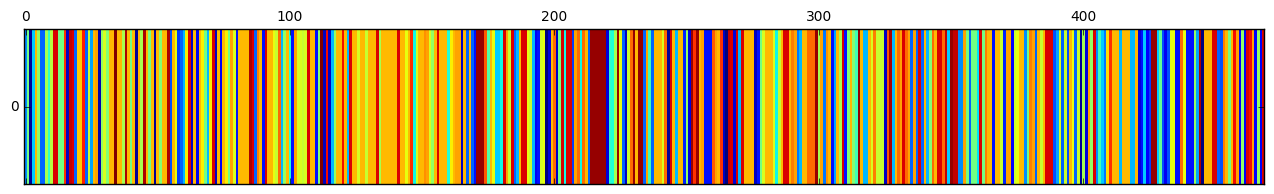

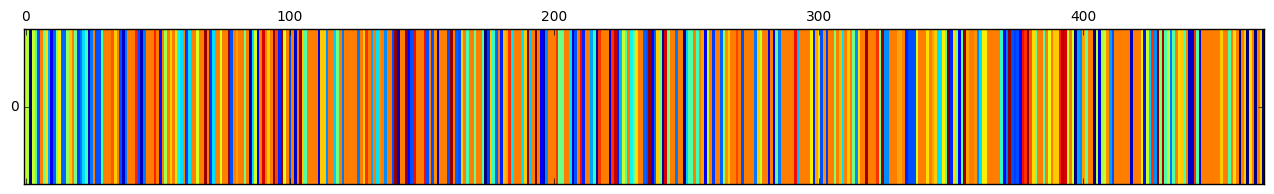

In [104]:
plt.matshow(X_topics_idf_lables, aspect='auto')
plt.matshow(X_topics_lables, aspect='auto')
plt.matshow(doc_topic_lables, aspect='auto')
plt.matshow(doc_topic_idf_lables, aspect='auto')


plt.show()

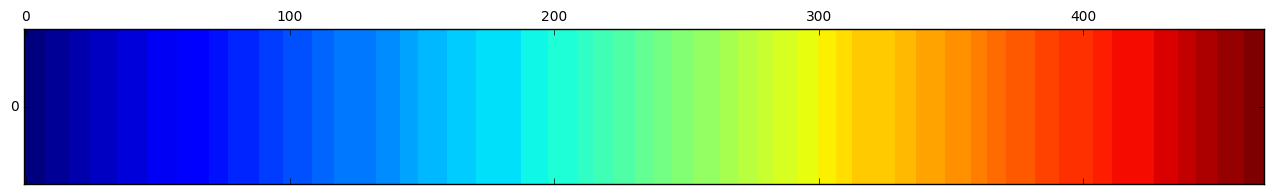

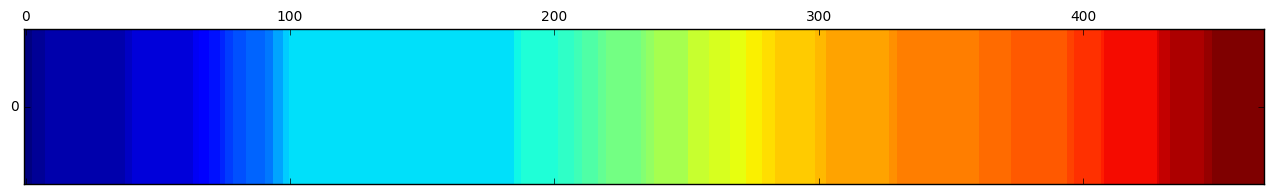

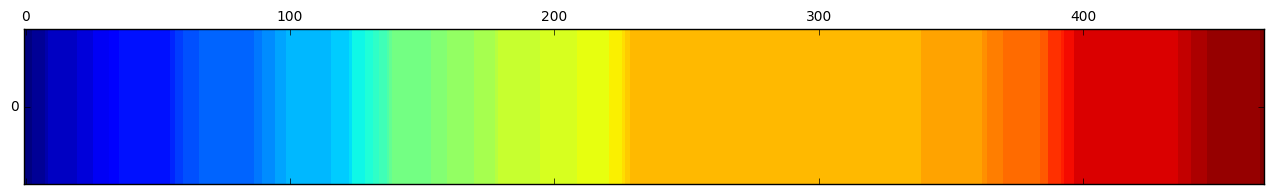

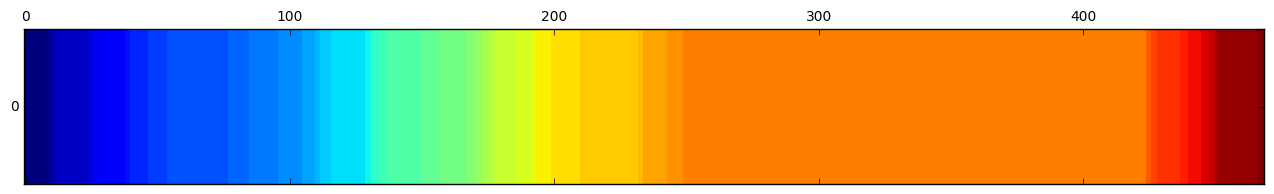

In [105]:
plt.matshow(np.sort(X_topics_idf_lables), aspect='auto')
plt.matshow(np.sort(X_topics_lables), aspect='auto')
plt.matshow(np.sort(doc_topic_lables), aspect='auto')
plt.matshow(np.sort(doc_topic_idf_lables), aspect='auto')

plt.show()

In [106]:
from sklearn import metrics

x_score = metrics.silhouette_score(tf_matrix, lables_arr(X_topics))
x_score_idf = metrics.silhouette_score(tf_matrix, lables_arr(X_topics_idf))
scikit_score = metrics.silhouette_score(tf_matrix, lables_arr(doc_topic))
scikit_idf_score_tf = metrics.silhouette_score(tf_matrix, lables_arr(doc_topic_idf))
scikit_idf_score = metrics.silhouette_score(tf_idf_matrix, lables_arr(doc_topic_idf))

print x_score
print x_score_idf
print scikit_score
print scikit_idf_score_tf
print scikit_idf_score


-0.292538492013
-0.218407063006
-0.317590979212
-0.337636910889
-0.00624687282085


In [109]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

normalize_tf = normalize(tf)
normalize_tf_idf = normalize(tf_idf)
normalize_tf_idf_int = normalize(sparse_matrix_to_arr(dok_matrix(tf_idf_int)))
pca = PCA(n_components=2)
X_topics_pca = pca.fit(normalize_tf).transform(normalize_tf)
X_topics_pca_idf = pca.fit(normalize_tf_idf_int).transform(normalize_tf_idf_int)
doc_topic_pca = pca.fit(normalize_tf).transform(normalize_tf)
doc_topic_pca_idf = pca.fit(normalize_tf_idf).transform(normalize_tf_idf)

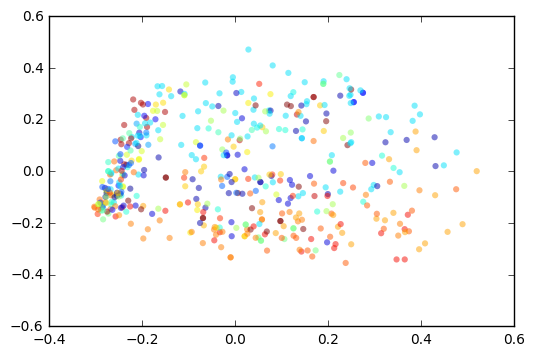

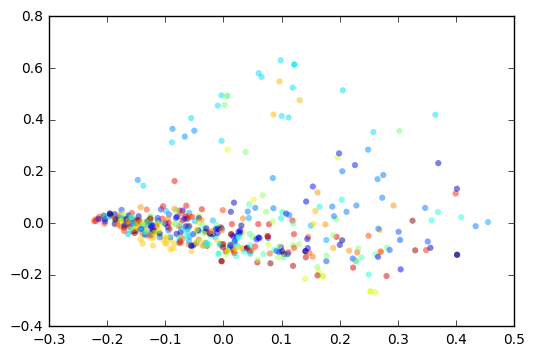

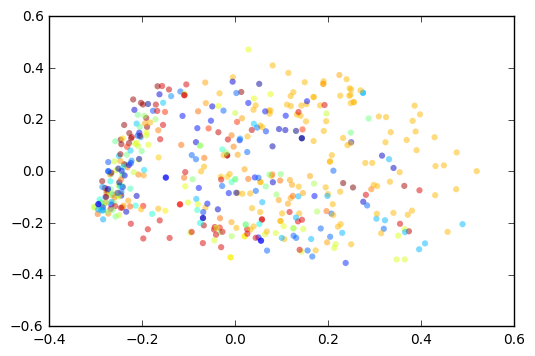

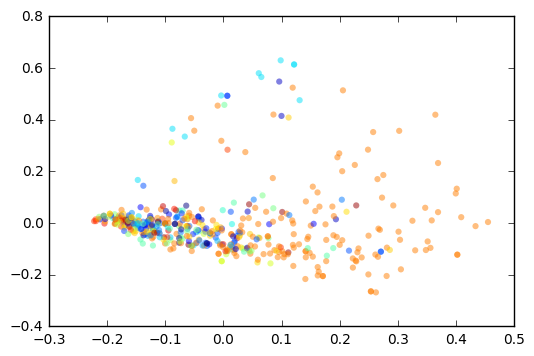

In [110]:


plt.scatter([x[0] for x in X_topics_pca], [y[1] for y in X_topics_pca], c=X_topics_lables, alpha=0.5, linewidths=0)
plt.show()

plt.scatter([x[0] for x in X_topics_pca_idf], [y[1] for y in X_topics_pca_idf], c=X_topics_idf_lables, alpha=0.5, linewidths=0)
plt.show()

plt.scatter([x[0] for x in doc_topic_pca], [y[1] for y in doc_topic_pca], c=doc_topic_lables, alpha=0.5, linewidths=0)
plt.show()

plt.scatter([x[0] for x in doc_topic_pca_idf], [y[1] for y in doc_topic_pca_idf], c=doc_topic_idf_lables, alpha=0.5, linewidths=0)
plt.show()

In [113]:
print "scikit idf:"
print_top_words(lda_model_scikit_idf.components_, n_top_words, doc_topic_idf_lables)
print "scikit:"
print_top_words(lda_model_scikit.components_, n_top_words, doc_topic_lables)
print "lda: "
print_top_words(topic_word, n_top_words, X_topics_lables)
print "lda idf:"
print_top_words(lda_model2.topic_word_, n_top_words, X_topics_idf_lables)

scikit idf:
Topic #38: - 175
trump think donald going people romney presidentelect would
Topic #10: - 23
president obama also world states says united meeting
Topic #34: - 22
get could lot administration really talk much state
Topic #48: - 15
meeting jersey golf water cia club director biggest
Topic #17: - 13
hamilton pence cast theater show vice sir cheers
Topic #22: - 13
thing big part government man wall car called
Topic #3: - 12
night deal peru listen lima meet least summit
Topic #12: - 11
working chance plan set words cities relationship friends
Topic #33: - 11
secretary two comes york clinton wants run looking
Topic #24: - 10
half guys class illegal hey trail everyone history
Topic #36: - 9
fear trip hate muslims inside worried questions crimes
Topic #13: - 9
diversity elected step huge south lose handle promised
Topic #0: - 9
fact film court seeing stand jail judiciary kennedy
Topic #42: - 9
snow storm weather military conditions northeast force minnesota
Topic #29: - 8
care mar

In [152]:
from datetime import datetime, timedelta
print int(time.time())
int(time.mktime((datetime.now() + timedelta(hours=0)).timetuple()))

1479701253


1479701253